In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from yellowbrick.regressor import ResidualsPlot

In [2]:
df_month = pd.read_parquet('./cleaned_housing_month.parquet')

In [3]:
df_month['target'] = df_month.groupby('area')['average_price'].shift(-1)

In [4]:
df_month = df_month.dropna()

In [5]:
df_month_model = df_month[['average_price', 'houses_sold', 'target']]

X = df_month_model.drop('target', axis=1)
y = df_month_model.target.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [6]:
# Lasso regression model 
ts_cv = TimeSeriesSplit(n_splits=3)

lass = Lasso(alpha=0.8, normalize=True)
lass.fit(X_train, y_train)
np.mean(cross_val_score(lass, X_train, y_train, scoring='neg_mean_absolute_error', cv=ts_cv ))

-4018.092739014335

,alpha,error
19,0.8,-4299.915462


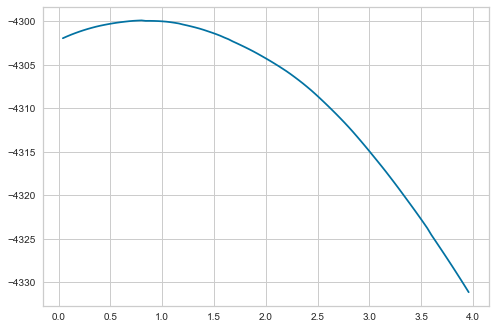

In [7]:
alpha = []
error = []

for i in range(1, 100):
    alpha.append(i/25)
    las = Lasso(alpha=(i/25), normalize=True)
    error.append(np.mean(cross_val_score(las, X_train, y_train, scoring='neg_mean_absolute_error', )))

plt.plot(alpha, error)

err = tuple(zip(alpha, error))
df_err = pd.DataFrame(err, columns=['alpha', 'error'])
df_err[df_err.error == max(df_err.error)]

In [8]:
# Storing Predictions of the model
ypred_lass = lass.predict(X_test)

In [9]:
# Testing the prediction

print(mean_absolute_error(y_test, ypred_lass))        # MAE
print((mean_squared_error(y_test, ypred_lass))**0.5)  # RMSE
print(r2_score(y_test, ypred_lass))                   # R2 SCORE

4407.143802529962
7516.951517405741
0.9986836835916565


In [10]:
# Checking coefficients and intercept
cdf = pd.DataFrame(lass.coef_, X_train.columns, columns=['Coefficients'])
intercept = lass.intercept_
print(cdf)
print(intercept)

               Coefficients
average_price      1.001411
houses_sold        3.783661
-124.37541879806668


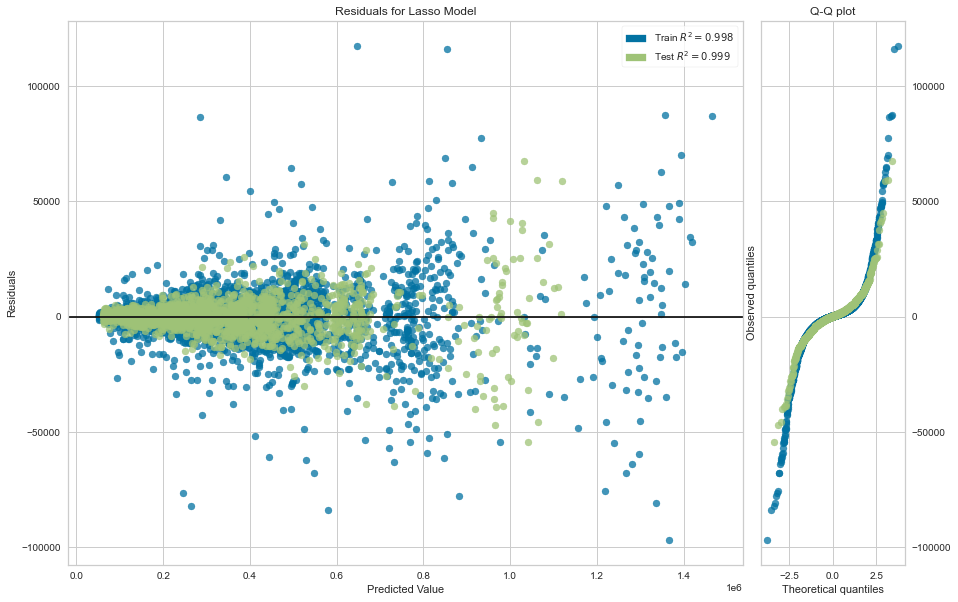

<AxesSubplot:title={'center':'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [11]:
# Residual plots to determine heteroscedasticity and whether constant variance is violated

residual = ResidualsPlot(lass, hist=False, qqplot=True, size=(1080,720))

residual.fit(X_train, y_train)
residual.score(X_test, y_test)
residual.show()              

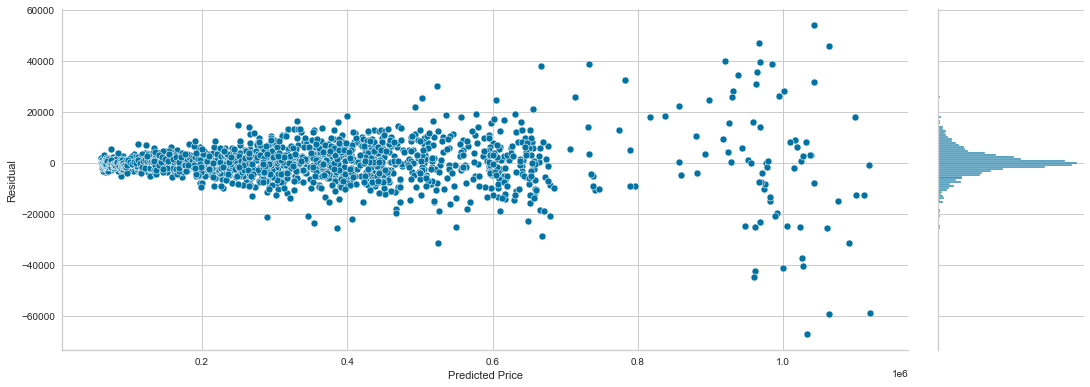

In [12]:
with sns.axes_style('whitegrid'):
    r = sns.jointplot(x=ypred_lass, y=y_test-ypred_lass, height=12)
    r.set_axis_labels('Predicted Price', 'Residual')
    r.fig.set_figwidth(15)
    r.fig.set_figheight(6)
    r.ax_marg_x._visible=False